# Setup

## Imports

In [1]:
from multiprocessing import Pool
import h5py 
import mat73
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import ttest_1samp
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

## Load File Paths

In [5]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
subs = ['07']
file_paths = {}

for sub in subs:
    # create a dictionary holding the file paths
    ncsl_share = '/mnt/ncsl_share'
    file_paths[sub] = {
        'setup_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Setup.mat',
        'raw_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Raw.mat',
        'data_path': ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject{sub}_snapshot_normalized.npy', # movement onset as event
        'data_path' : ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/show-card_pre-2sec_post-4sec/Subject{sub}_snapshot_normalized.npy', # visual cue as event
        'out_path_metrics': f'Metrics/Subject{sub}_vis_stim',
        'out_path_plots': f'Plots/Subject{sub}_vis_stim'
    }

In [6]:
raw_file = h5py.File(file_paths['07']['raw_path'])
setup_data = mat73.loadmat(file_paths['07']['setup_path'])

out_path_plots = file_paths['07']['out_path_plots']
out_path_metrics = file_paths['07']['out_path_metrics']

In [7]:
setup_data.keys()

dict_keys(['elec_area', 'elec_ind', 'elec_name', 'filters', 'trial_times', 'trial_words'])

## Instantiate variables

In [8]:
bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

bets = bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [9]:
elec_names = np.array(setup_data['elec_name'])
elec_areas = np.array(setup_data['elec_area'])

In [21]:
data = np.load(file_paths['07']['data_path'])[:,:,:,40:80] # 40:80 = 0s:2s
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

## Matplotlib Settings

In [11]:
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

## Create Frequency Bands

In [22]:
wavelet_freqs = np.logspace(np.log2(2),np.log2(150),num=63,base=2)

frequency_band_indices ={
    "Delta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 0.5 and freq < 4],
    "Theta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 4 and freq < 8],
    "Alpha" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 8 and freq < 14],
    "Beta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 14 and freq < 30],
    "Gamma" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 30]
}

In [23]:
f_band_data = np.zeros((data.shape[0], data.shape[1], 5, data.shape[3]))

for i, key in enumerate(frequency_band_indices):
    f_band_data[:,:,i,:] = data[:,:,frequency_band_indices[key],:].mean(2)

# Classes

In [14]:
def _generate_sampled_channels(channels, sample_size, sampled_channels_=[]):
    """Recursively generate a list (size = sample_size) of lists of sampled channels"""
    np.random.seed()

    if len(channels) > sample_size:
        sample = np.random.choice(channels, size=sample_size, replace=False)
        sampled_channels_.append(list(sample))
        channels = np.delete(channels, np.where(np.isin(channels, sample))[0])
        _generate_sampled_channels(channels, sample_size, sampled_channels_)
    else:
        sampled_channels_.append(list(channels))

    return sampled_channels_

def _find_combinations(n, k):
    """Find all possible combinations of k channels from n channels

    Return
    ------
    combinations_list : list
        List of tuples containing the indices all possible combinations of k channels from n channels
    """
    population = list(range(0, n))
    combinations_list = list(itertools.combinations(population, k))
    return combinations_list

def _get_collective_predictions(predictions):
    # Get the collective prediction for each trial
    collective_predictions = []

    for trial_predictions in predictions:
        if trial_predictions.mean() >= 0.5:
            collective_predictions.append(1)
        else:
            collective_predictions.append(0)

    # for i in range(len(predictions[0])):
    #     if predictions[:, i].mean() >= 0.5:
    #         collective_predictions.append(1)
    #     else:
    #         collective_predictions.append(0)
    
    return collective_predictions

def _get_collective_prediction_accuracy(collective_predictions, y):
    # Get the accuracy of theveloped a circuit model of decision-making which accounts for the specificity of inputs to and outputs from inhibitory neurons. We found that selective inhibition expands the space of circuits supporting decision-making, allowing for weaker or stronger recurrent excitation when connected in a competitive or feedback motif. The specificity of inhibitory outputs sets te collective prediction
    accuracy = (y == collective_predictions).mean()
    return accuracy

In [15]:
class Estimator(object):
    def __init__(self, data, setup_data):
        self._num_trials, self._num_channels, self._num_freqs, self._num_timesteps = data.shape
        
        self._elec_areas = setup_data['elec_area']
        self._elec_names = setup_data['elec_name']

    def create_X(self, data, channel, time):
        """Create the X data that will be used to train the LDA model"""
        if hasattr(self, '_time_resolution') and type(self._time_resolution) == int:
            X = data[:, channel, :, time:time+self._time_resolution].mean(-1)
        elif type(time) == list and len(time) == 2:
            if time[0] - time[1] == 0:
                X = data[:, channel, :, time[0]]
            else:
                X = data[:, channel, :, time[0]:time[1]].mean(-1)
        else:
            pass

        return X
    
    def filter_channels(self):
        """Filters out channels that are in particular anatomical locations"""
        filtered_elec_areas_idxs = [i for i,ea in enumerate(self._elec_areas) if ea not in ['white matter','CZ','PZ', 'out','FZ','cerebrospinal fluid','lesion L','ventricle L','ventricle R']]
        filtered_elec_areas = [self._elec_areas[i] for i in filtered_elec_areas_idxs]
        filtered_num_channels = len(filtered_elec_areas_idxs)

        return filtered_elec_areas_idxs, filtered_elec_areas, filtered_num_channels
    
    def set_attributes(self, **kwargs):
        """Set class attributes specified by the dataset and metadata"""
        if 'time_resolution' in kwargs:
            if not(self._num_timesteps % kwargs['time_resolution'] == 0):
                raise Exception("Invalid time resolution size, num_timesteps % resolution must equal 0")
            else:
                self._time_resolution = kwargs['time_resolution']
                self._timesteps_rescaled = int(self._num_timesteps/kwargs['time_resolution'])

In [16]:
class LDA(Estimator):
    def __init__(self, data, setup_data):
        super().__init__(data, setup_data)
        self._reset_metrics()
        
    def _reshape_attributes(self, new_shape:tuple):
        """Reshape class attributes to specified shape"""
        for attr_name in self.__dict__.keys():
            if not attr_name.startswith('_'):
                setattr(self, attr_name, np.reshape(getattr(self, attr_name), new_shape))

    def _reset_metrics(self):
        self.mean_scores = []
        self.std_scores = []
        self.dvals = []
        self.t_stats = []
        self.p_vals = []
        self.low_bet_avg_powers = []
        self.high_bet_avg_powers = []
        self.diff_avg_powers = []
        self.lda_coefs = []

    def train(self, X, y):
        """Train LDA model on specified X data and y labels"""
        low_bet_avg_powers = X[np.where(y == 0)].mean(0)
        high_bet_avg_powers = X[np.where(y == 1)].mean(0)
        diff_avg_powers = high_bet_avg_powers - low_bet_avg_powers

        self.high_bet_avg_powers.append(high_bet_avg_powers)
        self.low_bet_avg_powers.append(low_bet_avg_powers)
        self.diff_avg_powers.append(diff_avg_powers)

        # Using RepeatedKFold() for training LDA
        rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

        estimators = []
        scores = []
        dval = np.zeros(self._num_trials)

        for train, test in rkf.split(X):
            lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
            lda.fit(X[train], y[train])
            estimators.append(lda)
            scores.append(lda.score(X[test], y[test]))
            dval[test] = np.dot(X[test], lda.coef_.T).T[0] + lda.intercept_

        self.dvals.append(dval)
        self.lda_coefs.append(estimators[scores.index(max(scores))].coef_[0])
        self.mean_scores.append(np.mean(scores))
        
        self.std_scores.append(np.std(scores))

        t_stat, p_val = ttest_1samp(dval, popmean=0) # perform 1-sided t-test on decision values corresponding to high bet
        
        self.t_stats.append(t_stat)
        self.p_vals.append(p_val)
    
    def create_cluster_idxs(self, threshold):
        """Creates statistical clusters based on the t-statistics computed from LDA decision values"""
        if self.t_stats.shape == (self._num_channels, self._timesteps_rescaled, 1):
            cluster_idxs = []

            for channel in range(self._num_channels):
                ch_cluster_idxs = []
                threshold_idxs = [i for i, t_stat in enumerate(self.t_stats[channel].flatten()) if np.abs(t_stat) > threshold]
                temp_cluster_idxs = [threshold_idxs[0]]
            
                # Groups consecutive clusters together
                for i in range(len(threshold_idxs) - 1):
                    if threshold_idxs[i+1] - threshold_idxs[i] == 1:
                        temp_cluster_idxs.append(threshold_idxs[i+1])
                    else:
                        ch_cluster_idxs.append(temp_cluster_idxs)
                        temp_cluster_idxs = [threshold_idxs[i+1]]
                
                if len(temp_cluster_idxs) != 0:
                    ch_cluster_idxs.append(temp_cluster_idxs)
                
                cluster_idxs.append(ch_cluster_idxs)
            
            return cluster_idxs
        else:
            Exception('Cannot create clusters with these attributes, make sure shape of attributes is (num_channels, timesteps_rescaled, 1)')

    def compute_t_stat_clusters(self, threshold):
        """Computes the sum of the t-statistics in each cluster"""
        t_stat_sums = []

        for channel in range(self._num_channels):
            temp_t_stat_sums = []
            for arr in self.create_cluster_idxs(threshold)[channel]:
                temp_t_stat_sums.append(self.t_stats[channel][arr].sum())
            
            t_stat_sums.append(temp_t_stat_sums)
        
        return t_stat_sums

In [104]:
class TrainOptimalTimeWindows(LDA):
    def __init__(self, data, setup_data) -> None:
        super().__init__(data, setup_data)

    def _create_time_windows(self):
        """Create all possible time windows from which X data can be created."""
        time_windows = []
        for i in range(self._num_timesteps):
            for j in range(self._num_timesteps):
                if i-j >= 0 and i+j <= self._num_timesteps:
                    time_windows.append([i-j,i+j])
                else:
                    break
        
        return time_windows
    
    def _get_predictions(self):
        predictions = []

        # Get predictions for each trial by each channel
        for trial in range(self._num_trials):
            trial_predictions = []
            for dval in self.dvals[:,trial]:
                if dval >= 0:
                    channel_prediction = 1
                else:
                    channel_prediction = 0
                trial_predictions.append(channel_prediction)
            
            predictions.append(trial_predictions)

        predictions = np.asarray(predictions)

        return predictions
    
    def _grid_search_on_channel_combinations(self, y, max_channels=20):
        assert max_channels <= 20, 'Cannot perform grid search on more than 20 channels'

        predictions = self._get_predictions()
            # Find all possible channel combinations to use for collective prediction
        all_channel_idxs_combinations = []
        for i in range(max_channels):
            # Find all possible channel combinations of length i+1
            channel_combinations = _find_combinations(max_channels, i+1)
            all_channel_idxs_combinations.append(channel_combinations)

        # Grid search on optimal channel combination to use for collective prediction
        accuracies = []

        for k_length_combinations in all_channel_idxs_combinations:
            k_length_combination_accuracies = []
            for combination in k_length_combinations:
                # Stores all the predictions for this particular combination of k channels
                combination = list(combination)
                combination_predictions = predictions[:,combination]

                # Stores the collective prediction for this particular combination of k channels
                collective_combination_predictions = _get_collective_predictions(combination_predictions)

                # Get the accuracy of the collective prediction for each combination of k channels
                k_length_combination_accuracies.append(_get_collective_prediction_accuracy(collective_combination_predictions, y))
            
            accuracies.append(k_length_combination_accuracies)

        return all_channel_idxs_combinations, accuracies

    def _time_window_grid_search(self, data, y, channels):
        """Train LDA model on all possible time windows, store the time windows that correspond with the highest LDA score."""

        time_windows = self._create_time_windows()
        best_time_windows = []

        for channel in channels:
            for times in time_windows:
                X = super().create_X(data, channel, times)
                super().train(X,y)

            print(f'Channel {channel} done')
            best_time_windows.append([channel, time_windows[np.argmax(self.mean_scores)], np.max(self.mean_scores)])
            super()._reset_metrics()
        
        return best_time_windows

    def _multiprocessing_time_window_grid_search(self, data, y, n_processes, filter_channels:bool = True):
        """Perform a time window grid search in parallel"""
        if filter_channels:
            filtered_elec_areas_idxs, _, __ = super().filter_channels()
            channels = filtered_elec_areas_idxs
        else:
            channels = np.arange(self._num_channels)

        sample_size = round(len(channels)/n_processes)

        sampled_channels = _generate_sampled_channels(channels, sample_size, [])

        # if __name__ == '__main__':
        with Pool(n_processes) as p:
            results = p.starmap(self._time_window_grid_search, [(data, y, channels) for channels in sampled_channels])
            p.close()
        
        return results

    def train_on_optimal_time_windows(self, data, y, n_processes, n_channels=10, filter_channels:bool=True):
        """Train LDA model on the optimal time windows for top performing channels, specified by n_channels"""
        results = self._multiprocessing_time_window_grid_search(data, y, n_processes, filter_channels=filter_channels)

        # Unravel the results from the multiprocessing and sort them by channels
        optimal_time_windows_per_channel = [item for sublist in results for item in sublist]
        optimal_time_windows_per_channel.sort(key=lambda x: x[0])
        optimal_time_windows_per_channel.sort(key=lambda x: x[2], reverse=True)
        self._optimal_time_windows_per_channel = optimal_time_windows_per_channel

        for channel, times, _ in optimal_time_windows_per_channel[:n_channels]:
            X = super().create_X(data, channel, times)
            super().train(X,y)
        
        super()._reshape_attributes((n_channels,-1))

    def get_group_accuracies(self, y):
        """Get all the collective prediction accuracies of top channels for all group sizes"""
        predictions = self._get_predictions()
        accuracies = []

        for i in range(predictions.shape[1]):
            # Get collective prediction of channels 0 to i
            collective_predictions = _get_collective_predictions(predictions[:,:i+1])
            accuracies.append(_get_collective_prediction_accuracy(collective_predictions, y))
        
        peak_accuracy_group_idx = np.argmax(accuracies)

        return accuracies, peak_accuracy_group_idx

    def get_optimal_channel_combination(self, y, max_channels=20):
        """
        Get the optimal channel combination to use for collective prediction. 
        Channels used to find combination is specified by max_channels.
        """

        all_channel_idxs_combinations, accuracies = self._grid_search_on_channel_combinations(y, max_channels=max_channels)

        optimal_time_windows_per_ch = self._optimal_time_windows_per_channel
        max_accuracies = []

        for i, accuracies in enumerate(accuracies):
            optimal_chs = []
            ch_idxs = all_channel_idxs_combinations[i][np.argmax(accuracies)]
            for idx in ch_idxs:
                optimal_chs.append(optimal_time_windows_per_ch[idx][0])

            max_accuracies.append([optimal_chs, np.max(accuracies)])

        max_accuracies.sort(key=lambda x: x[1], reverse=True)

        return max_accuracies
    
    def plot_accuracies(self, y, out_path:str=None):
        """Plot the collective prediction accuracy for each group size of top performing channels"""
        accuracies, peak_accuracy_group_idx = self.get_group_accuracies(y)

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.plot(np.arange(len(accuracies)) + 1, accuracies)
        ax.set_title('Accuracy of Majority Concensus')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Number of Top Performing Channels in Group')
        ax.axvline(peak_accuracy_group_idx + 1, color = 'red', alpha=0.5)
        ax.annotate(f'(Group Size for Peak Accuracy: {peak_accuracy_group_idx + 1}\nScore: {accuracies[peak_accuracy_group_idx]:.2f})', xy=(peak_accuracy_group_idx,np.mean(accuracies)), fontsize = 12)

        plt.savefig(out_path + '_optimal_time_window_all_group_accuracies.png')
        plt.show()

    def plot_heatmap(self, channels:list, event_delay:int, top_accuracy:float = None, optimal_combination:bool=False, out_path:str=None):
        """
        Plot a heatmap of the accuracy of the selected channels for their respective time windows.
        Heatmap is sorted by the accuracy of the time window.
        """

        # Convert the number of time steps to seconds
        time = np.arange(self._num_timesteps)/20 - event_delay # 20 is the number of timesteps per second

        optimal_time_window_info_for_channels = []

        for channel in channels:
            optimal_time_window_info = [lst for lst in self._optimal_time_windows_per_channel if lst[0] == channel]
            optimal_time_window_info_for_channels.append(optimal_time_window_info[0])

        # Ensures that channels are sorted by the start time of their time windows
        optimal_time_window_info_for_channels.sort(key=lambda x: x[1][1])
        optimal_time_window_info_for_channels.sort(key=lambda x: x[1][0])

        channels_sorted_by_time_window = [lst[0] for lst in optimal_time_window_info_for_channels]
        print(channels_sorted_by_time_window)

        accuracies = []

        heatmap_array = np.zeros((len(channels), self._num_timesteps))

        # Get the locations of the channels from the data strucure
        
        for i, (channel, time_window, accuracy) in enumerate(optimal_time_window_info_for_channels):
            # If time_window is exactly at one timestep, visualize the time window to be one timestep larger
            if time_window[0] - time_window[1] == 0:
                time_window = [time_window[0], time_window[1]+1]

            heatmap_array[i,time_window[0]:time_window[1]] = accuracy
            accuracies.append(accuracy)

        fig, axs = plt.subplots(1, 1, figsize=(10, 25))
        sns.heatmap(heatmap_array, ax=axs, cmap='PRGn', vmin=np.min(accuracies)-.05, vmax=np.max(accuracies), center=np.min(accuracies)-.05, cbar_kws={"label":"Channel Accuracy"})
        
        if optimal_combination:
            axs.set_title(f'Accuracy of Optimal Combination of Channels for a Given Time Window\nAccuracy: {top_accuracy:.2f}')
            path = out_path + '_optimal_time_window_and_combination_heatmap.png'
        else:
            axs.set_title(f'Accuracy of Top {len(channels)} Channels for a Given Time Window\nAccuracy: {top_accuracy:.2f}')
            path = out_path + '_optimal_time_window_heatmap.png'
        
        axs.set_ylabel('Channel')
        axs.set_xlabel('Time (s)')
        axs.set_xticks(np.arange(0, self._num_timesteps, 5))
        axs.set_xticklabels(time[::5])
        axs.set_yticks(np.arange(len(channels))+0.5)
        axs.set_yticklabels(np.asarray(self._elec_areas)[channels_sorted_by_time_window], rotation = 0)
        axs.axvline(np.where(time == 0), color = 'blue', alpha=1, ls = '--')

        axs.tick_params(axis='y', pad=25)

        plt.savefig(path, bbox_inches='tight')
        plt.show()

In [15]:
class PerChannelTimestep(LDA):
    """Visualizes model performance for LDA models trained on each channel and timestep of the data."""

    def __init__(
        self,
        data,
        setup_data
        ) :
        super().__init__(data, setup_data)

    def _sort_scores(self, filter_channels:bool):
        """Sort channels from greatest to least maximum LDA scores, and indicate timepoint at which maximum LDA score occurs."""
        max_mean_scores = np.zeros((self._num_channels,3))

        for channel in range(self._num_channels):
            max_mean_scores[channel, 0] = int(channel) # store the channel index
            max_mean_scores[channel, 1] = list(self.mean_scores[channel]).index(max(self.mean_scores[channel])) # the time point at which the maximum mean score occurs
            max_mean_scores[channel, 2] = max(self.mean_scores[channel]) # value of the maximum mean score in a particular channel for all time points

        if filter_channels == True:
            filtered_elec_areas_idxs, _, __ = super().filter_channels()
            sorted_indices = max_mean_scores[filtered_elec_areas_idxs,2].argsort()[::-1]
            self.sorted_max_mean_scores = max_mean_scores[filtered_elec_areas_idxs][sorted_indices]
            self.sorted_elec_names = [self._elec_names[i] for i in np.int_(self.sorted_max_mean_scores[:, 0])]
            self.sorted_elec_areas = [self._elec_areas[i] for i in np.int_(self.sorted_max_mean_scores[:, 0])]
            
        else:
            sorted_indices = max_mean_scores[:,2].argsort()[::-1]
            self.sorted_max_mean_scores = max_mean_scores[sorted_indices]
            self.sorted_elec_names = [self._elec_names[i] for i in sorted_indices]
            self.sorted_elec_areas = [self._elec_areas[i] for i in sorted_indices]

    def train_per_channel_and_timestep(self, data, y, time_resolution, filter_channels:bool = True):
        """Train an LDA model on each channel and timestep"""
        super().set_attributes(time_resolution=time_resolution)

        for channel in range(self._num_channels):
            for time in range(self._timesteps_rescaled):
                X = super().create_X(data, channel, time*self._time_resolution)
                super().train(X, y)

        super()._reshape_attributes((self._num_channels,self._timesteps_rescaled,-1))
        self._sort_scores(filter_channels)

    def plot_sorted_scores(self, out_path:str):
        """Visualize the LDA model scores (sorted from greatest to least) for all channels."""
        num_channels = len(self.sorted_max_mean_scores)
        
        fig, axs = plt.subplots(3, 1, figsize=(24,24), gridspec_kw={'height_ratios' : [1,1,1]})

        axs[0].set_title('Sorted Peak Score of LDA Models (from greatest to least)')
        axs[0].set_ylabel('Peak Mean Score')
        axs[0].set_xlabel('Channels (from most to least accurate)')
        axs[0].plot(np.arange(0,num_channels,1), self.sorted_max_mean_scores[:,2])

        axs[1].set_title('Scatter Plot of Peak Score of LDA Models (from greatest to least) with error bars')
        axs[1].set_ylabel('Peak Mean Score')
        axs[1].set_xlabel('Channels (from most to least accurate)')
        axs[1].scatter(np.arange(0,num_channels,1), self.sorted_max_mean_scores[:,2])
        axs[1].errorbar(np.arange(0,num_channels,1), self.sorted_max_mean_scores[:,2], yerr=self.std_scores[np.int_(self.sorted_max_mean_scores[:,0]),np.int_(self.sorted_max_mean_scores[:,1])].flatten(), fmt="o")
        
        axs[2].set_title('Time of Peak Score of LDA Models')
        axs[2].set_ylabel('Time (seconds)')
        axs[2].set_xlabel('Channels (from most to least accurate)')
        time = self.sorted_max_mean_scores[:,1]/(20/self._time_resolution) - 3 # LOOKUP
        axs[2].scatter(np.arange(0, num_channels), time)
        axs[2].axhline(y = 0, color = 'red', alpha=0.5)

        fig.tight_layout()
        fig.savefig(out_path + f'_sorted_scores')
        
        plt.figure(figsize=(24,24))
        plt.title('Sorted Peak Score of LDA Models (from greatest to least)')
        plt.ylabel('Channel Names')
        plt.xlabel('Score')
        plt.hlines(y=np.arange(0,num_channels), xmin=0.5, xmax=self.sorted_max_mean_scores[:,2][::-1],
            color='blue', alpha=0.6, linewidth=2)
        plt.yticks(np.arange(0,num_channels), labels=self.sorted_elec_areas[::-1])

        plt.savefig(out_path + f'_sorted_scores_hline')
    
    def plot_sorted_scores_per_channel(self, num_plots:int, out_path:str):
        """Visualize the LDA model scores over time for top performing channels."""
        time_resolution = self._time_resolution
        timesteps_rescaled = self._timesteps_rescaled
        
        times = (np.arange(0, timesteps_rescaled, 1) / (20/time_resolution)) - 3 # time 0 seconds denotes when the subject starts moving (i.e. 3 seconds into the data)

        fig, axs = plt.subplots(num_plots, 1, figsize=(24, 8 * num_plots))

        for i, trial_data in enumerate(self.sorted_max_mean_scores[:num_plots]):
            channel, time, peak_accuracy = trial_data
            time = time/(20/time_resolution) - 3 # LOOKUP event delay
            ax = axs[i]
            ax.plot(times[:], self.mean_scores[int(channel)])
            ax.set_title('Electrode %s in the %s' %(self.sorted_elec_names[i], self.sorted_elec_areas[i]))
            ax.set_ylabel('Score')
            ax.set_xlabel('Time (seconds)')
            # ax.tick_params(axis='both', labelsize=12)
            ax.axvline(time, color = 'red', alpha=0.5)
            ax.axvline(0, color = 'blue', alpha=0.5, ls = '--')
            ax.annotate(f'(Time: {time:.2f}s, Score: {peak_accuracy:.2f})', xy=(time + .05 ,.6), fontsize = 12)
        
        plt.savefig(out_path + f'_sorted_scores_per_channel')
        plt.show()

    def plot_power_heatmap(self, plot_metric, num_plots:int, out_path:str):
        """Plot heatmaps of high/low frequency powers, difference in high/low frequency powers, and LDA coefficients."""
        num_freqs = self._num_freqs
        time_resolution = self._time_resolution
        timesteps_rescaled = self._timesteps_rescaled

        if timesteps_rescaled >= 50:
            num_xticks = int(timesteps_rescaled/2)
        else:
            num_xticks = timesteps_rescaled

        xticks = np.linspace(0, timesteps_rescaled - 1, num=num_xticks, dtype=np.int_)
        xticklabels = np.around(np.linspace(0, timesteps_rescaled - 1, num=num_xticks, dtype=np.int_)/(20/time_resolution) - 3, decimals=2)

        if num_freqs == 5: 
            # sets the y-tick labels for EEG frequency bands
            yticks = np.arange(num_freqs)
            yticklabels = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
        else:
            # sets the y-tick labels for all frequencies in data
            yticks = np.arange(num_freqs, step=2)
            yticklabels = [round(i,1) for i in np.logspace(np.log2(2),np.log2(150), num = len(yticks),base=2, dtype=np.float16)]

        for i, trial_data in enumerate(self.sorted_max_mean_scores[:num_plots]):
            channel, time, peak_accuracy = trial_data

            low_bet_powers = self.low_bet_avg_powers[int(channel)]
            high_bet_powers = self.high_bet_avg_powers[int(channel)]
            diff_bet_powers = self.diff_avg_powers[int(channel)]
            lda_coef = self.lda_coefs[int(channel)]

            fig, axs = plt.subplots(2, 2,figsize=(24, 20))
            
            # Plot power per frequency as a function of time, power averaged across all respective trials (high or low bet trials) 
            sns.heatmap(high_bet_powers.T, ax=axs[0][0], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
            axs[0][0].set_title('Electrode %s in the %s \n High Bet Z-Scored Frequency Power (n = %s)' %(self.sorted_elec_names[i], self.sorted_elec_areas[i], "~"))
            axs[0][0].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")

            sns.heatmap(low_bet_powers.T, ax=axs[0][1], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
            axs[0][1].set_title('Electrode %s in the %s \n Low Bet Z-Scored Frequency Power (n = %s)' %(self.sorted_elec_names[i], self.sorted_elec_areas[i], "~"))
            axs[0][1].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")

            # Plots the difference in power frequency for high and low bet trials
            sns.heatmap(diff_bet_powers.T, ax=axs[1][0], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power", "pad": 0.1}, cmap='PRGn')
            axs[1][0].set_title('Electrode %s in the %s \n Difference in Z-Scored Frequency Power (High - Low Bet)' %(self.sorted_elec_names[i], self.sorted_elec_areas[i]))
            axs[1][0].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
            ax = axs[1][0].twinx()
            sns.lineplot(x=np.arange(0,timesteps_rescaled), y=plot_metric[int(channel)].flatten(), color='blue', ax=ax) # Make the overlayed metric an optional variable user can select
            ax.set_ylabel('Mean LDA Score')
            axs[1][0].axvline(time, color = 'red', alpha=0.5)
            axs[1][0].axvline(0, color = 'blue', alpha=0.25, ls = '--')

            # Plots the LDA coefficients for each frequency band over time
            sns.heatmap(lda_coef.T, ax=axs[1][1], vmin=-1, vmax=1, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
            axs[1][1].set_title('LDA coefficient values for all frequencies \n at %s in %s' %(self.sorted_elec_names[i], self.sorted_elec_areas[i]))
            axs[1][1].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")

            for axs_ in axs:
                for ax in axs_:
                    ax.set_xticks(xticks, labels = xticklabels)
                    ax.set_yticks(yticks)
                    ax.set_yticklabels(yticklabels, rotation = 0)
                    ax.axes.invert_yaxis()
                    ax.axvline(time, color = 'red', alpha=0.5)
                    ax.axvline(12, color = 'blue', alpha=0.5, ls = '--')

                    for label in ax.xaxis.get_ticklabels()[1::2]:
                        label.set_visible(False)

            plt.savefig(out_path + '_heatmap_%s_%s'%(self.sorted_elec_names[i], self.sorted_elec_areas[i]))
            plt.show()


In [16]:
class PerTimestepAllChannels(LDA):

    """Visualizes model performance for LDA models trained on all channels at each timestep of the data."""

    def __init__(
        self,
        data,
        setup_data
        ) :
        super().__init__(data, setup_data)
        
    def _sort_scores(self):
        """Sort the LDA scores from greatest to least, with indexes of channels saved."""
        enumerated_mean_scores = np.array(list(enumerate(self.mean_scores.flatten())))
        sorted_indices = enumerated_mean_scores[:,1].argsort()[::-1]
        self.sorted_mean_scores = enumerated_mean_scores[sorted_indices]

    def _convert_timesteps_to_time(self, event_delay):
        """Convert timesteps into seconds while specifying timepoint 0."""
        self.__event_delay = event_delay
        # time point "0 seconds" denoted by event_delay
        self.__times = (np.arange(0, self._timesteps_rescaled) / (20/self._time_resolution)) - event_delay 

    
    def plot_sorted_scores(self, out_path:str):
        """Visualize the LDA model scores (sorted from greatest to least) for all timepoints."""
        num_timesteps = self._timesteps_rescaled
        xticks = np.arange(0,num_timesteps,1)
        
        fig, axs = plt.subplots(3, 1, figsize=(24,24), gridspec_kw={'height_ratios' : [1,1,1]})

        axs[0].set_title('Sorted Peak Score of LDA Models (from greatest to least)')
        axs[0].set_ylabel('Mean Score')
        axs[0].set_xlabel('Times (from most to least accurate)')
        axs[0].set_xticks(xticks, labels = self.__times[np.int_(self.sorted_mean_scores[:,0])])
        axs[0].plot(xticks ,self.sorted_mean_scores[:,1])

        axs[1].set_title('Scatter Plot of Peak Score of LDA Models (from greatest to least) with error bars')
        axs[1].set_ylabel('Mean Score')
        axs[1].set_xlabel('Times (from most to least accurate)')
        axs[1].set_xticks(xticks, labels = self.__times[np.int_(self.sorted_mean_scores[:,0])])
        axs[1].scatter(xticks, self.sorted_mean_scores[:,1])
        axs[1].errorbar(xticks, self.sorted_mean_scores[:,1], yerr=self.std_scores[np.int_(self.sorted_mean_scores[:,0])].flatten(), fmt="o")

        axs[2].set_title('Sorted Peak Score of LDA Models (from greatest to least)')
        axs[2].set_ylabel('Times (from most to least accurate)')
        axs[2].set_xlabel('Score')
        axs[2].hlines(y=np.arange(0,num_timesteps), xmin=0.5, xmax=self.sorted_mean_scores[:,1][::-1],
            color='blue', alpha=0.6, linewidth=2)
        axs[2].set_yticks(np.arange(0,num_timesteps), labels=self.__times[np.int_(self.sorted_mean_scores[:,0])][::-1])

        fig.tight_layout()
        fig.savefig(out_path + '_sorted_scores_per_timestep_all_channels')
    
    def plot_power_heatmap(self, out_path:str):
        """Plot heatmaps of high/low frequency powers, difference in high/low frequency powers, and LDA coefficients."""
        num_freqs = self._num_freqs
        time_resolution = self._time_resolution
        timesteps_rescaled = self._timesteps_rescaled

        low_bet_powers = self.low_bet_avg_powers
        high_bet_powers = self.high_bet_avg_powers
        diff_bet_powers = self.diff_avg_powers
        lda_coef = self.lda_coefs

        if timesteps_rescaled >= 50:
            num_xticks = int(timesteps_rescaled/2)
        else:
            num_xticks = timesteps_rescaled

        if num_freqs == 5: 
            # sets the y-ticks when using EEG frequency bands
            yticks = np.arange(diff_bet_powers.shape[1], step=5)
        else:
            # sets the y-ticks when using all frequencies in data
            yticks = np.arange(diff_bet_powers.shape[1], step=63)
            # yticklabels = [round(i,1) for i in np.logspace(np.log2(2),np.log2(150), num = len(yticks),base=2, dtype=np.float16)]

        xticks = np.linspace(0, timesteps_rescaled - 1, num=num_xticks, dtype=np.int_)
        xticklabels = np.around(np.linspace(0, timesteps_rescaled - 1, num=num_xticks, dtype=np.int_)/(20/time_resolution) - self.__event_delay, decimals=2)

        fig, axs = plt.subplots(2, 2,figsize=(24, 20))
        
        # Plot power per frequency as a function of time, power averaged across all respective trials (high or low bet trials) 
        sns.heatmap(high_bet_powers.T, ax=axs[0][0], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
        axs[0][0].set_title('High Bet Z-Scored Frequency Power')

        sns.heatmap(low_bet_powers.T, ax=axs[0][1], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
        axs[0][1].set_title('Low Bet Z-Scored Frequency Power')

        # Plots the difference in power frequency for high and low bet trials
        sns.heatmap(diff_bet_powers.T, ax=axs[1][0], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power", "pad": 0.1}, cmap='PRGn')
        axs[1][0].set_title('Difference in Z-Scored Frequency Power (High - Low Bet)')
        ax = axs[1][0].twinx()
        sns.lineplot(x=np.arange(0,timesteps_rescaled), y=self.mean_scores.flatten(), color='blue', ax=ax) # Make the overlayed metric an optional variable user can select
        ax.set_ylabel('Mean LDA Score')

        # Plots the LDA coefficients for each frequency band over time
        sns.heatmap(lda_coef.T, ax=axs[1][1], vmin=-1, vmax=1, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
        axs[1][1].set_title('LDA coefficient values (on channels and frequencies)')

        for axs_ in axs:
            for ax in axs_:
                ax.set_xticks(xticks, labels = xticklabels, rotation = 90)
                ax.set_yticks(yticks)
                ax.set(xlabel="Time (seconds)", ylabel="Frequency Bands * Channels")
                ax.axes.invert_yaxis()
                ax.axvline(self.sorted_mean_scores[0,0], color = 'red', alpha=0.5)
                ax.axvline(12, color = 'blue', alpha=1, ls = '--')

                for label in ax.xaxis.get_ticklabels()[1::2]:
                    label.set_visible(False)

        plt.savefig(out_path + '_heatmap_per_timestep_all_channels')
        plt.show()

    def plot_contributing_channels(self, alpha):
        """Visualize the heatmap of the LDA coefficients for top channels with mean LDA coefficient absolute values greater than alpha."""
        num_freqs = self._num_freqs
        time_resolution = self._time_resolution
        timesteps_rescaled = self._timesteps_rescaled

        if timesteps_rescaled >= 50:
            num_xticks = int(timesteps_rescaled/2)
        else:
            num_xticks = timesteps_rescaled
        
        yticks = np.arange(num_freqs)
        yticklabels = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

        xticks = np.linspace(0, timesteps_rescaled - 1, num=num_xticks, dtype=np.int_)
        xticklabels = np.around(np.linspace(0, timesteps_rescaled - 1, num=num_xticks, dtype=np.int_)/(20/time_resolution) - self.__event_delay, decimals=2)


        avg_coefs = np.abs(self.lda_coefs).mean(0)
        idxs = []

        for i in avg_coefs.argsort()[::-1]:
            if avg_coefs[i] > alpha:
                idxs.append(i)
            else:
                break
        
        channels = [int(i/self._num_freqs) for i in idxs]

        fig, axs = plt.subplots(len(idxs), 1, figsize=(12,7*len(idxs)))

        for i, ch in enumerate(channels):
            ch_idx = ch*self._num_freqs
            sns.heatmap(self.lda_coefs.T[ch_idx:ch_idx+self._num_freqs], ax=axs[i], cmap='PRGn')

            axs[i].set_xticks(xticks, labels = xticklabels, rotation = 90)
            axs[i].set_xlabel('Time (seconds)')
            axs[i].set_yticklabels(yticklabels, rotation = 0)
            axs[i].set_ylabel('Frequency Band')
            axs[i].axes.invert_yaxis()
            axs[i].axvline(self.sorted_mean_scores[0,0], color = 'red', alpha=0.5)
            axs[i].axvline(12, color = 'blue', alpha=1, ls = '--')
            axs[i].set_title('Electrode %s in the %s \n LDA Coefficients' %(self._elec_names[ch], self._elec_areas[ch]))

        plt.tight_layout()

    def train_on_all_channels(self, data, y, time_resolution, filter_channels:bool = True, custom_channels = None):
        """Train an LDA model on all the channels for each timestep"""
        super().set_attributes(time_resolution=time_resolution)

        for time in range(self._timesteps_rescaled):
            if filter_channels:
                filtered_elec_areas_idxs, _, __ = super().filter_channels()
                X = super().create_X(data, filtered_elec_areas_idxs, time*self._time_resolution)
            elif not custom_channels == None:
                X = super().create_X(data, custom_channels, time*self._time_resolution)
            else:
                X = super().create_X(data, np.arange(0,self._num_channels), time*self._time_resolution)

            X_reshaped = X.reshape(self._num_trials,-1)
            super().train(X_reshaped,y)
        
        super()._reshape_attributes((self._timesteps_rescaled,-1))
        self._sort_scores()
        self._convert_timesteps_to_time(3)


In [17]:
class AllTimesteps(LDA):
    def train_on_all_timesteps(self, data, y):
        """Train an LDA model on all the timesteps for each channel"""
        for channel in range(self._num_channels):
            X = super().create_X(data, channel, np.arange(self._num_timesteps))
            X_reshaped = X.reshape(self._num_trials, -1)
            super().train(X_reshaped, y)
        
        super()._reshape_attributes((self._num_channels,-1))


In [18]:
class ShuffledLDA(PerChannelTimestep):
    def __init__(self, data, setup_data):
        super().__init__(data, setup_data)
        self._reset_metrics()
        
    def _get_hand(self, setup_data):
        """Get the subject's card value at a particular trial"""
        bets = setup_data['filters']['bets']
        good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

        self.__sub_hand = setup_data['filters']['card1'][good_trials] # get the subject's card hand for the good trials
    
    def _shuffle_y(self, y, setup_data):
        """
        Randomly shuffle the elements of y to be in different locations.

        Parameters
        ----------
        y : arr, required
            The labels that the LDA model is to be trained on

        Returns
        -------
        y_shuffled : arr
            An array with the elements of y randomly shuffled to be in different locations.
        """
        
        np.random.seed()

        print('Shuffling!')

        # Get the locations for each particular card value
        self._get_hand(setup_data)
        card_value_indices = []
        for i in [2,4,6,8,10]:
            card_value_indices.append(np.where(self.__sub_hand == i)[0])

        y_shuffled = np.zeros(y.shape)

        # Ensure that the number of high bets in the shuffled y labels is consistent with the card value
        for indices in card_value_indices:
            temp = indices
            num_high_bets = y[indices].sum() + round(np.random.uniform(-1,1)*y[indices].sum()*0.2) # Get the number of high bets for a particular card value and add some randomness to it
            for _ in range(num_high_bets):
                if np.any(temp):
                    # Pick a random location from all possible locations of that particular card value and set it to 1 (ie high bet)
                    rand = np.random.choice(temp)
                    y_shuffled[rand] = 1
                    rand_index = np.where(temp == rand)[0]
                    temp = np.delete(temp,rand_index) # Remove that location from being able to be chosen again
            y_shuffled[temp] = 0 # set all other locations for that particular card value to 0 (ie low bet)

        return y_shuffled
    
    def train_per_channel_and_timestep(self, data, y, setup_data, time_resolution):
        """Use shuffled y labels to train LDA model on each channel and timestep"""
        y_shuffled = self._shuffle_y(y, setup_data)
        super().train_per_channel_and_timestep(data, y_shuffled, setup_data=setup_data, time_resolution=time_resolution)

    def compute_t_stat_clusters(self, ref_estimator, threshold):
        """Computes the sum of the t-statistics for a cluster specified by a reference LDA estimator"""
        t_stat_sums = []

        for channel in range(self._num_channels):
            temp_t_stat_sums = []
            for arr in ref_estimator.create_cluster_idxs(threshold)[channel]:
                temp_t_stat_sums.append(self.t_stats[channel][arr].sum())
            
            t_stat_sums.append(temp_t_stat_sums)
        
        return t_stat_sums

# Model Training

Using the power per wavelet scale for a particular channel and timepoint as a feature. 

In [105]:
lda = TrainOptimalTimeWindows(data=f_band_data, setup_data=setup_data)

In [42]:
f_band_data.shape

(162, 133, 5, 40)

In [106]:
filtered_num_channels = lda.filter_channels()[2]

In [107]:
lda.train_on_optimal_time_windows(f_band_data, y, n_processes=20, n_channels=filtered_num_channels)

Channel 36 done
Channel 123 done
Channel 94 done
Channel 9 done
Channel 39 done
Channel 28 done
Channel 103 done
Channel 104 done
Channel 58 done
Channel 13 done
Channel 102 done
Channel 128 done
Channel 101 done
Channel 76 done
Channel 87 done
Channel 59 done
Channel 77 done
Channel 119 done
Channel 2 done
Channel 61 done
Channel 42 done
Channel 97 done
Channel 19 done
Channel 79 done
Channel 62 done
Channel 21 done
Channel 88 done
Channel 95 done
Channel 29 done
Channel 17 done
Channel 53 done
Channel 54 done
Channel 7 done
Channel 16 done
Channel 67 done
Channel 69 done
Channel 124 done
Channel 32 done
Channel 3 done
Channel 109 done
Channel 34 done
Channel 89 done
Channel 86 done
Channel 111 done
Channel 37 done
Channel 45 done
Channel 27 done
Channel 63 done
Channel 75 done
Channel 44 done
Channel 51 done
Channel 8 done
Channel 112 done
Channel 74 done
Channel 22 done
Channel 78 done
Channel 126 done
Channel 105 done
Channel 52 done
Channel 43 done
Channel 122 done
Channel 38 done

In [45]:
lda._optimal_time_windows_per_channel

[[19, [27, 27], 0.6793560606060606],
 [89, [18, 22], 0.6660984848484849],
 [39, [34, 38], 0.6526515151515151],
 [109, [20, 28], 0.6465909090909091],
 [2, [13, 15], 0.6420454545454545],
 [3, [0, 34], 0.6414772727272727],
 [49, [6, 12], 0.6414772727272727],
 [88, [10, 26], 0.6414772727272727],
 [29, [14, 18], 0.6356060606060606],
 [9, [9, 11], 0.6352272727272728],
 [32, [10, 12], 0.6306818181818181],
 [33, [4, 6], 0.6301136363636364],
 [68, [13, 13], 0.6301136363636364],
 [101, [37, 39], 0.6299242424242424],
 [129, [6, 20], 0.6297348484848484],
 [119, [35, 39], 0.6295454545454545],
 [12, [6, 10], 0.6238636363636363],
 [123, [22, 30], 0.6236742424242424],
 [97, [26, 36], 0.6234848484848484],
 [52, [8, 10], 0.6232954545454545],
 [95, [8, 12], 0.6232954545454545],
 [8, [9, 9], 0.6231060606060607],
 [126, [16, 32], 0.6231060606060607],
 [125, [11, 11], 0.6231060606060606],
 [16, [18, 24], 0.6225378787878788],
 [18, [20, 32], 0.6178030303030303],
 [78, [35, 35], 0.6178030303030303],
 [124, [1

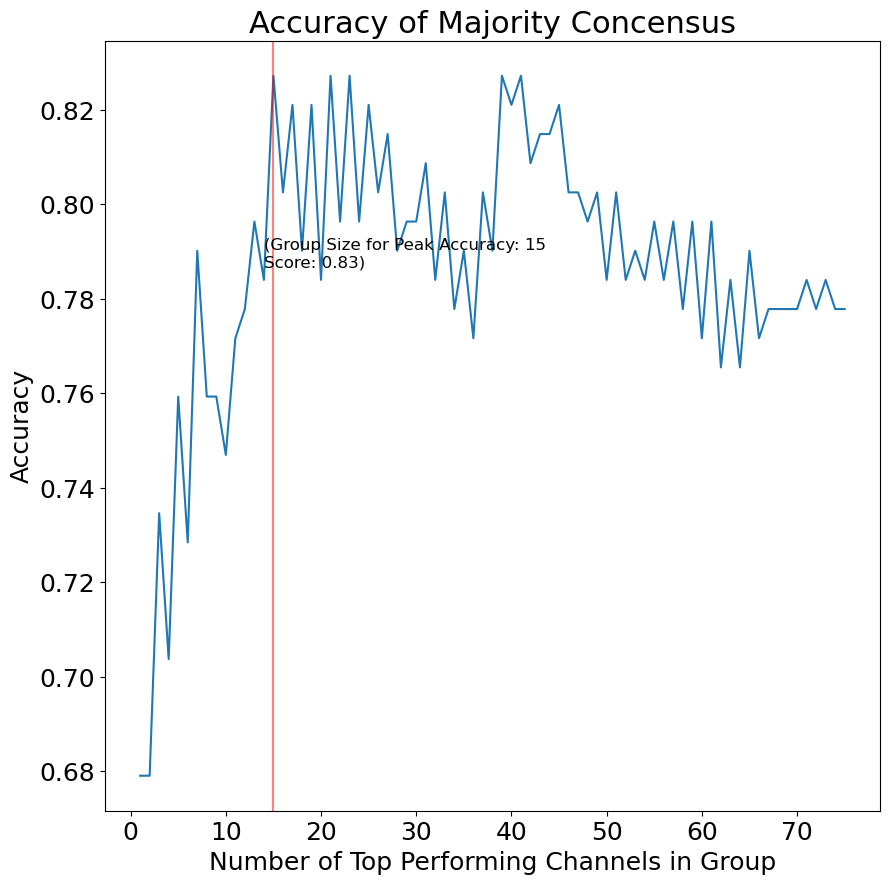

In [29]:
lda.plot_accuracies(y, out_path_plots)

In [99]:
def plot_heatmap(lda, channels:list, event_delay:int, top_accuracy:float = None, optimal_combination:bool=False, out_path:str=None):

    # Convert the number of time steps to seconds
    time = np.arange(lda._num_timesteps)/20 - event_delay # 20 is the number of timesteps per second

    optimal_time_window_info_for_channels = []

    for channel in channels:
        optimal_time_window_info = [lst for lst in lda._optimal_time_windows_per_channel if lst[0] == channel]
        optimal_time_window_info_for_channels.append(optimal_time_window_info[0])

    # Ensures that channels are sorted by time window start time
    optimal_time_window_info_for_channels.sort(key=lambda x: x[1][1])
    optimal_time_window_info_for_channels.sort(key=lambda x: x[1][0])

    channels_sorted_by_time_window = [lst[0] for lst in optimal_time_window_info_for_channels]
    print(channels_sorted_by_time_window)

    accuracies = []

    heatmap_array = np.zeros((len(channels),lda._num_timesteps))

    # Get the locations of the channels from the data strucure
    
    for i, (channel, time_window, accuracy) in enumerate(optimal_time_window_info_for_channels):
        # If time_window is exactly at one timestep, visualize the time window to be one timestep larger
        if time_window[0] - time_window[1] == 0:
            time_window = [time_window[0], time_window[1]+1]

        heatmap_array[i,time_window[0]:time_window[1]] = accuracy
        accuracies.append(accuracy)

    fig, axs = plt.subplots(1, 1, figsize=(10, 25))
    sns.heatmap(heatmap_array, ax=axs, cmap='PRGn', vmin=np.min(accuracies)-.05, vmax=np.max(accuracies), center=np.min(accuracies)-.05, cbar_kws={"label":"Channel Accuracy"})
    
    if optimal_combination:
        axs.set_title(f'Accuracy of Optimal Combination of Channels for a Given Time Window\nAccuracy: {top_accuracy:.2f}')
        #path = out_path + '_optimal_time_window_and_combination_heatmap.png'
    else:
        axs.set_title(f'Accuracy of Top {len(channels)} Channels for a Given Time Window\nAccuracy: {top_accuracy:.2f}')
        #path = out_path + '_optimal_time_window_heatmap.png'
    
    axs.set_ylabel('Channel')
    axs.set_xlabel('Time (s)')
    axs.set_xticks(np.arange(0, lda._num_timesteps, 5))
    axs.set_xticklabels(time[::5])
    axs.set_yticks(np.arange(len(channels))+0.5)
    axs.set_yticklabels(np.asarray(lda._elec_areas)[channels_sorted_by_time_window], rotation = 0)
    axs.axvline(np.where(time == 0), color = 'blue', alpha=1, ls = '--')

    axs.tick_params(axis='y', pad=25)

    # plt.savefig(path, bbox_inches='tight')
    plt.show()

[3, 33, 49, 129, 9, 32, 88, 68, 2, 29, 89, 109, 19, 39, 101]


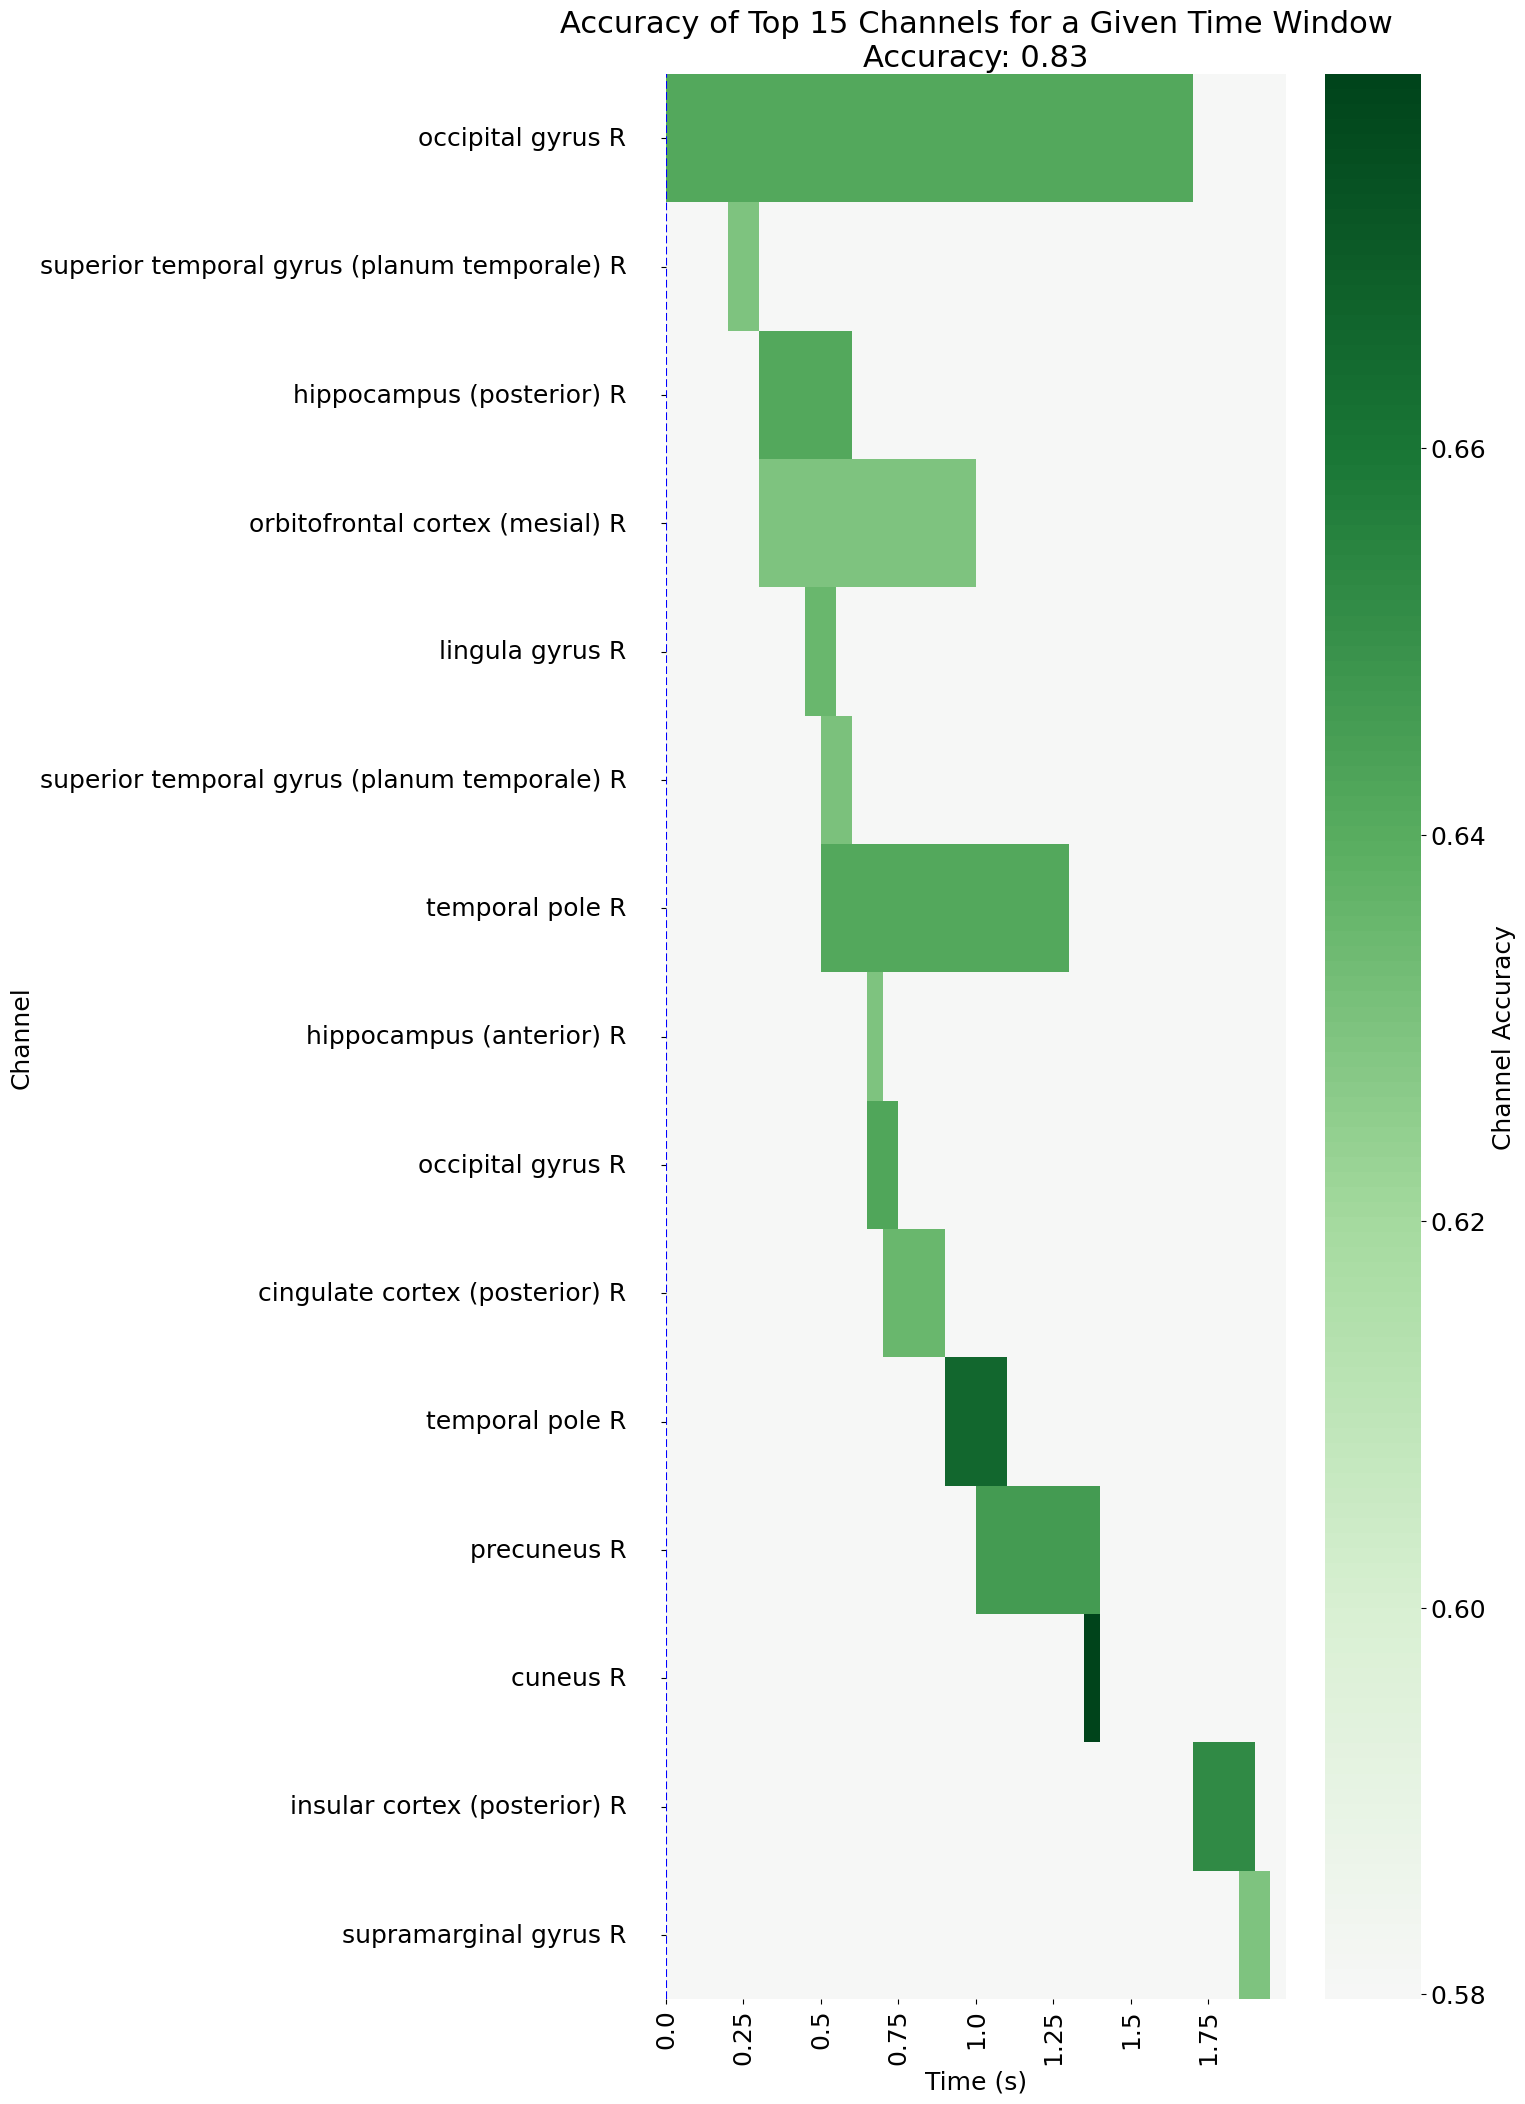

In [100]:
accuracies, peak_accuracy_group_idx = lda.get_group_accuracies(y)
top_chs = [ch for ch, _, _ in lda._optimal_time_windows_per_channel[:peak_accuracy_group_idx+1]]
# lda.plot_heatmap(top_chs,0, accuracies[peak_accuracy_group_idx], False, out_path_plots)
plot_heatmap(lda, top_chs, 0, accuracies[peak_accuracy_group_idx], False, None)

In [108]:
results = lda.get_optimal_channel_combination(y)

In [110]:
results[0]

[[19, 89, 39, 109, 2, 3, 49, 29, 33, 68, 97], 0.8580246913580247]

In [34]:
optimal_time_window_optimal_channel_combination = elec_areas[results[0][0]]
optimal_time_window_optimal_channel_combination

array(['superior temporal sulcus R', 'orbitofrontal cortex (lateral) R',
       'lingula gyrus R', 'superior temporal sulcus R', 'temporal pole R',
       'angular gyrus R', 'supramarginal gyrus R',
       'inferior temporal sulcus R', 'cingulate cortex (posterior) R',
       'parietooccipital sulcus R', 'supramarginal gyrus R'], dtype='<U44')

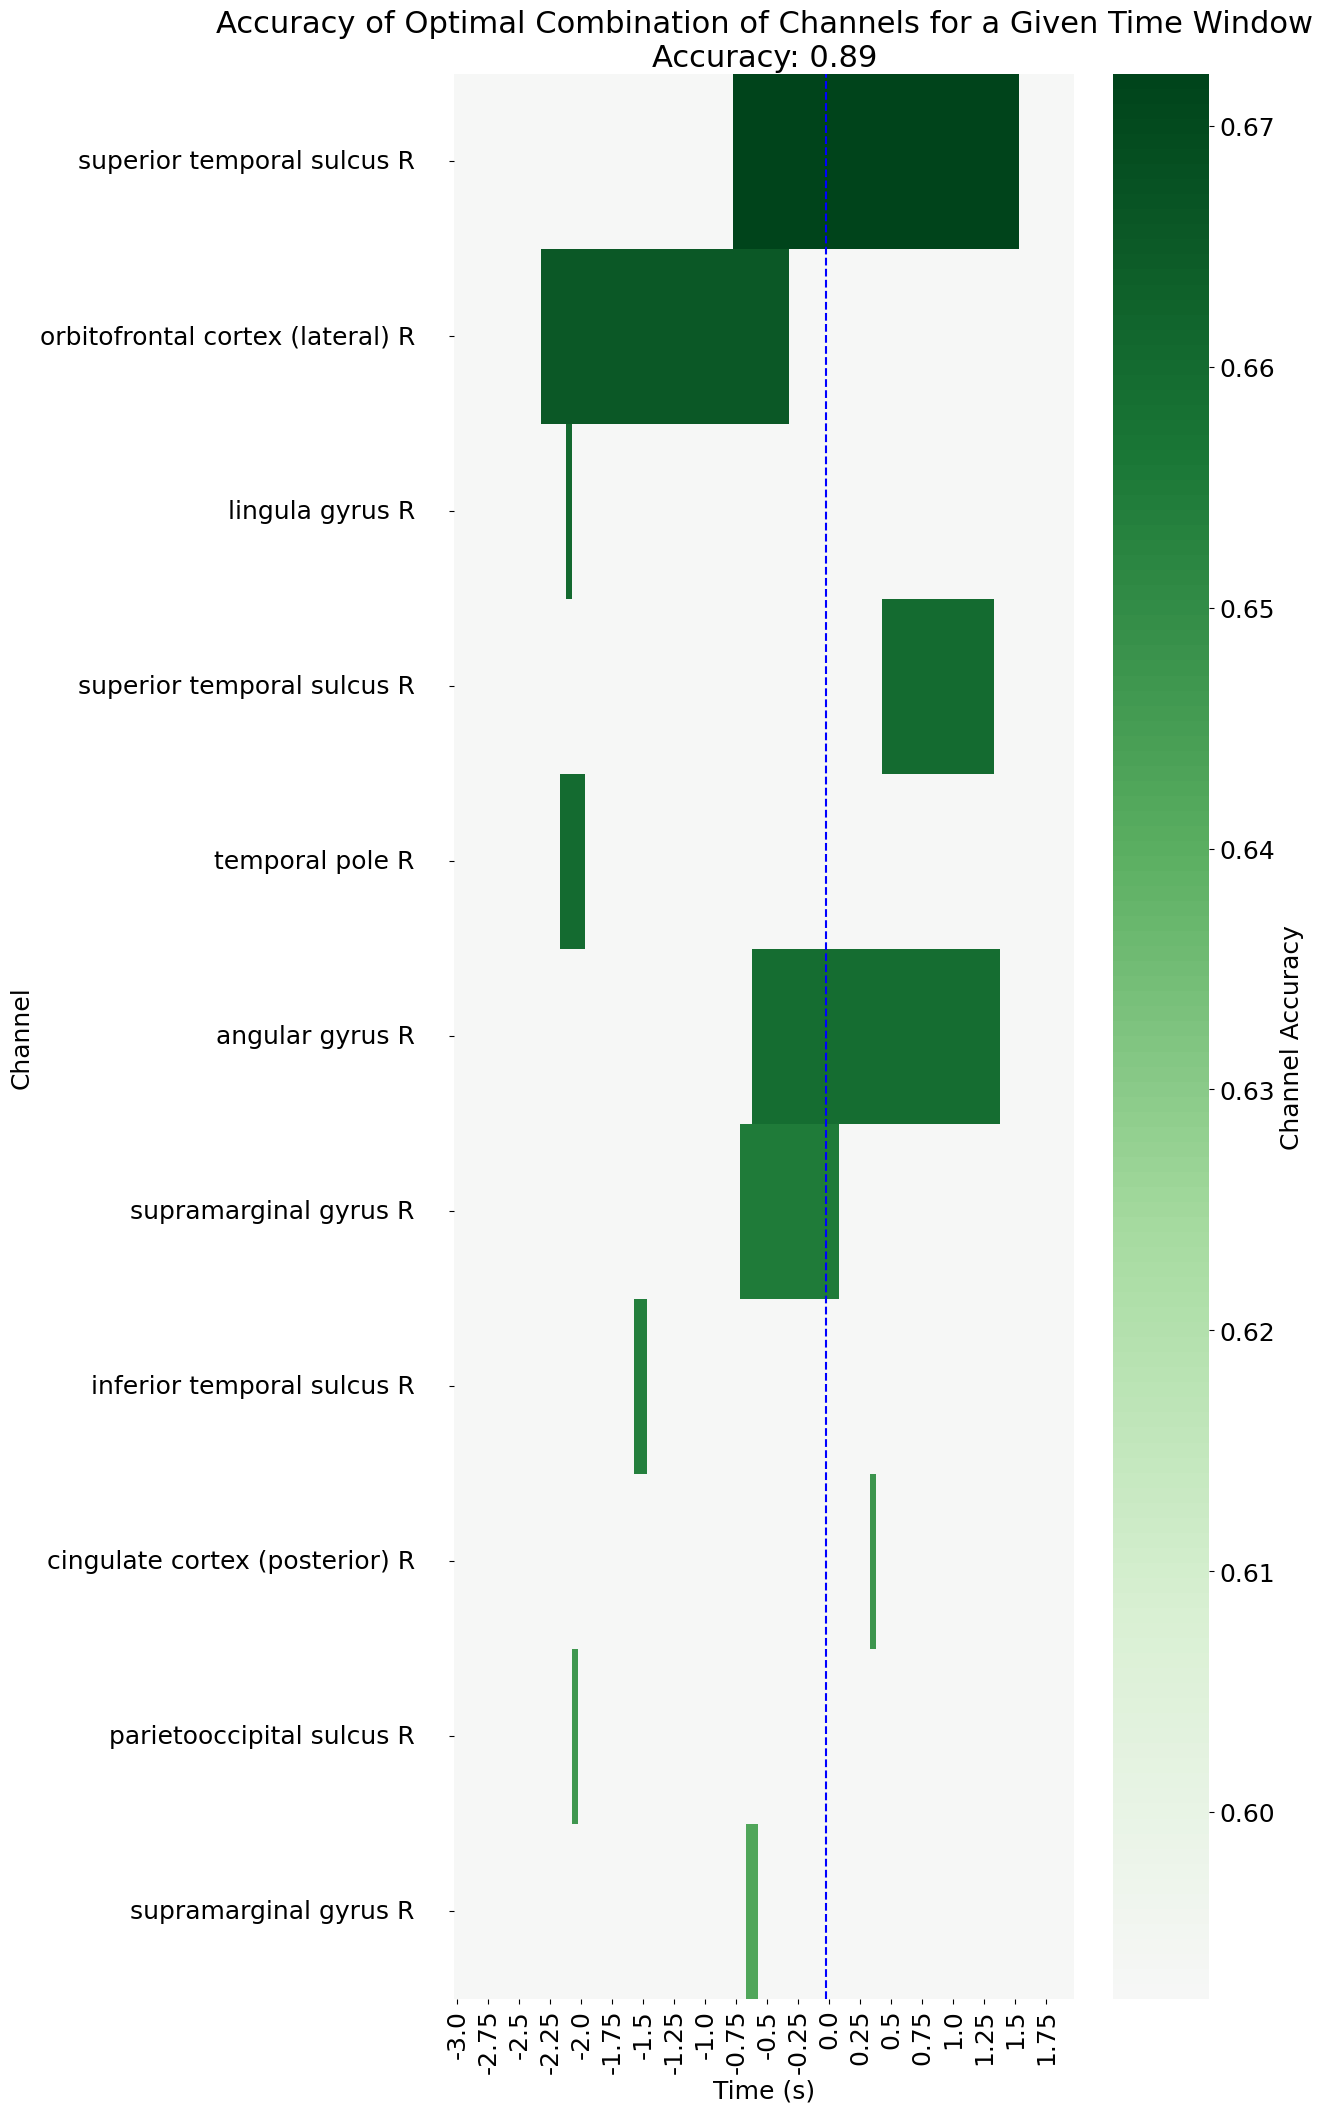

In [35]:
plot_heatmap(lda,results[0][0], 3, results[0][1], True, out_path_plots)

[3, 33, 49, 68, 2, 29, 89, 109, 97, 19, 39]


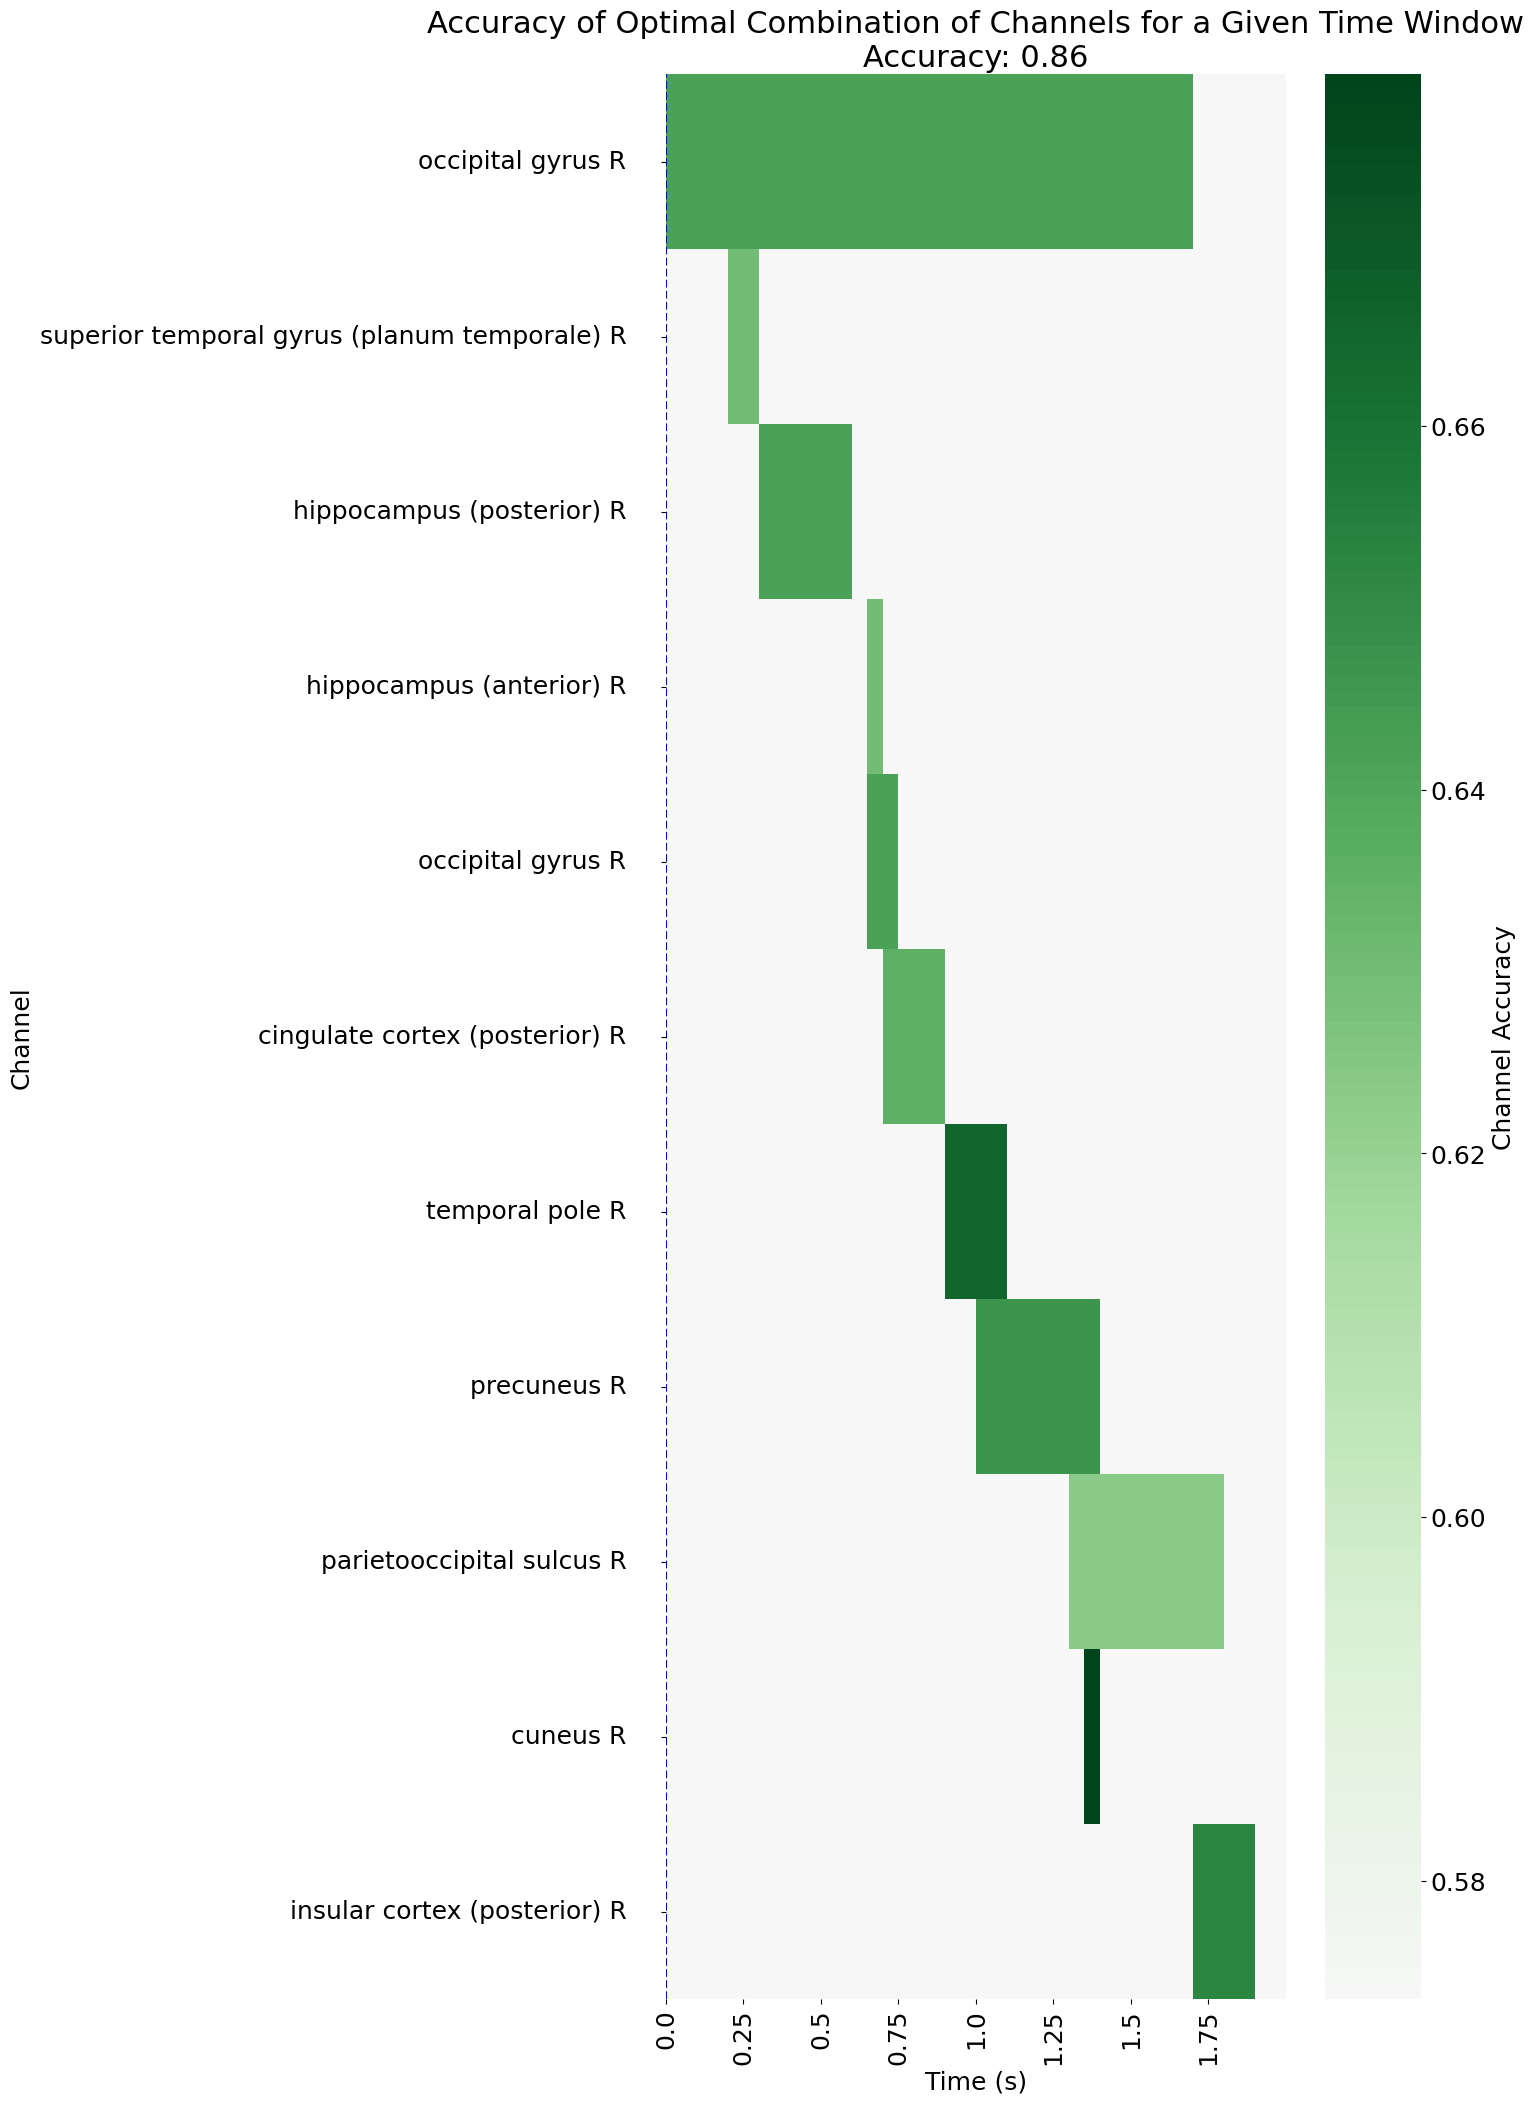

In [111]:
lda.plot_heatmap(results[0][0], 0, results[0][1], True, out_path_plots)

## Multiprocessing

In [49]:
def get_shuffled_t_stats(data, y, setup_data,  time_resolution, threshold, ref_estimator):
    shuffled_lda = ShuffledLDA(setup_data)
    shuffled_lda.train_per_channel_and_timestep(data, y, setup_data = setup_data, time_resolution=time_resolution)
    return shuffled_lda.compute_t_stat_clusters(ref_estimator, threshold)

In [50]:
from multiprocessing import Pool

n_processes = 20

if __name__ == '__main__':
    with Pool(n_processes) as p:
        results = p.starmap(get_shuffled_t_stats, [(f_band_data, y, setup_data, 5, 12, lda)] * 100)
        p.close()

Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!

# Visualization of Model Performance

# Extraneous Code

In [20]:
reg_channel_combinations = []
optimal_channel_combinations = []

subs = ['06','07','10','12','13','15','16','17','18','21']

for sub in subs:
    reg_channel_combinations.append(np.load(f'Metrics/Subject{sub}_optimal_time_window_channel_combination.npy'))
    optimal_channel_combinations.append(np.load(f'Metrics/Subject{sub}_optimal_time_window_optimal_channel_combination.npy'))

In [101]:
def find_common_channels(channel_combinations):
    common_channels_dict = {}

    for i in range(len(channel_combinations)):
        for j in range(len(channel_combinations) - i):
            common_channels = []
            if i != i+j:
                common_channels = list(set(channel_combinations[i]).intersection(channel_combinations[i+j]))
                if common_channels != []:
                    common_channels_dict[f'sub_{subs[i]}_and_sub_{subs[i+j]}'] = common_channels
    
    return common_channels_dict

In [100]:
for area in optimal_channel_combinations[1]:
    print(area)
    temp = area.split()[:-1]
    print(' '.join(temp))

superior temporal sulcus R
superior temporal sulcus
orbitofrontal cortex (lateral) R
orbitofrontal cortex (lateral)
lingula gyrus R
lingula gyrus
superior temporal sulcus R
superior temporal sulcus
temporal pole R
temporal pole
angular gyrus R
angular gyrus
supramarginal gyrus R
supramarginal gyrus
inferior temporal sulcus R
inferior temporal sulcus
cingulate cortex (posterior) R
cingulate cortex (posterior)
parietooccipital sulcus R
parietooccipital sulcus
supramarginal gyrus R
supramarginal gyrus


In [90]:
common_optimal_channels_dict = find_common_channels(optimal_channel_combinations)

In [92]:
common_channels_dict = find_common_channels(reg_channel_combinations)

In [91]:
common_optimal_channels_dict

{'sub_06_and_sub_13': ['fusiform gyrus L',
  'superior temporal gyrus (planum temporale) L'],
 'sub_06_and_sub_16': ['middle temporal gyrus L'],
 'sub_06_and_sub_17': ['fusiform gyrus L', 'middle temporal gyrus L'],
 'sub_06_and_sub_18': ['inferior temporal gyrus L'],
 'sub_07_and_sub_13': ['angular gyrus R'],
 'sub_07_and_sub_16': ['superior temporal sulcus R',
  'cingulate cortex (posterior) R',
  'angular gyrus R'],
 'sub_10_and_sub_12': ['insular cortex (anterior) R', 'parietal operculum R'],
 'sub_12_and_sub_16': ['superior temporal gyrus (planum temporale) R',
  'middle temporal gyrus R'],
 'sub_13_and_sub_16': ['occipital gyrus L', 'angular gyrus R'],
 'sub_13_and_sub_17': ['occipital gyrus L', 'fusiform gyrus L'],
 'sub_15_and_sub_18': ['parietooccipital sulcus L'],
 'sub_16_and_sub_17': ['occipital gyrus L', 'middle temporal gyrus L'],
 'sub_17_and_sub_21': ['supramarginal gyrus L']}

In [85]:
brain_areas = []
for areas in common_channels_dict.values():
    for area in areas:
        brain_areas.append(area)

In [86]:
brain_areas.sort()

In [88]:
brain_areas

['angular gyrus R',
 'angular gyrus R',
 'angular gyrus R',
 'cingulate cortex (posterior) R',
 'fusiform gyrus L',
 'fusiform gyrus L',
 'fusiform gyrus L',
 'inferior temporal gyrus L',
 'insular cortex (anterior) R',
 'middle temporal gyrus L',
 'middle temporal gyrus L',
 'middle temporal gyrus L',
 'middle temporal gyrus R',
 'occipital gyrus L',
 'occipital gyrus L',
 'occipital gyrus L',
 'parietal operculum R',
 'parietooccipital sulcus L',
 'superior temporal gyrus (planum temporale) L',
 'superior temporal gyrus (planum temporale) R',
 'superior temporal sulcus R',
 'supramarginal gyrus L']

In [ ]:
f_band_data.shape

(162, 133, 5, 120)

In [ ]:
ch_predictions_random = []
for i in range(133):
    ch_predictions_random.append(np.random.randint(0, 2, size=len(y)))
ch_predictions_random = np.array(ch_predictions_random)

In [ ]:
ch_predictions_random[:3].shape

(3, 162)

In [ ]:
collective_accuracies = []
collective_predictions = []

for i in range(133):
    collective_predictions.append(_get_collective_predictions(ch_predictions_random[:i+1]))
    collective_accuracies.append(_get_collective_prediction_accuracy(collective_predictions, y))

collective_predictions = np.array(collective_predictions)
collective_accuracies = np.array(collective_accuracies)

In [ ]:
collective_accuracies

array([0.5       , 0.51234568, 0.50823045, 0.51080247, 0.51358025,
       0.51748971, 0.52116402, 0.52006173, 0.521262  , 0.52160494,
       0.51964085, 0.52211934, 0.52184236, 0.52425044, 0.52222222,
       0.52391975, 0.52396514, 0.52400549, 0.52469136, 0.52716049,
       0.53027631, 0.53226712, 0.53408481, 0.53600823, 0.53654321,
       0.53632479, 0.53772291, 0.53813933, 0.53831418, 0.5382716 ,
       0.53803266, 0.53877315, 0.53853348, 0.53830792, 0.53809524,
       0.53789438, 0.5373707 , 0.53719948, 0.53719531, 0.53626543,
       0.53598314, 0.53527337, 0.53502728, 0.53493266, 0.53484225,
       0.53448739, 0.53467297, 0.53420782, 0.53388763, 0.53308642,
       0.53267974, 0.53181387, 0.53109713, 0.53017833, 0.5295174 ,
       0.52876984, 0.52869829, 0.52830992, 0.52793471, 0.52736626,
       0.52701882, 0.52658303, 0.52645503, 0.52594522, 0.52564103,
       0.52506547, 0.52459923, 0.52432825, 0.52406513, 0.52389771,
       0.52443053, 0.52426269, 0.524184  , 0.52410744, 0.52403